In [1]:
import scipy as sp
from scipy.io import arff
from cStringIO import StringIO
import pandas
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import sklearn.metrics.cluster as sk_cluster_m
import sklearn.metrics as skmetrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout


In [2]:
f="datasets/pen-based.arff"
data, meta = arff.loadarff(f)

In [3]:
#print meta
#print data.size
#print len(data[0])


### K-means

In [4]:
"""Function Utils"""
def rand_centroids(K, X):
    # rand_centroids(K=Int, X=Float_array):
    # Return a numpy array of size K with each element 
    # being a normally random distributed var with mu and sigma calculated 
    # from the mean and std of the data X
    mean, std = np.mean(X, axis=0), np.std(X, axis=0)
    clusters = [np.random.normal(mean, std) for n in range(K)]
    return np.array(clusters)

def euc_distance(X, Y):    
    # euc_distance(X=Float_array, Y=Float_array):
    # Returns an array of euclidean distances, 
    # for the square root of the sum of the square of the differences
    # of array X and array Y
    diff = X - Y[:, np.newaxis]
    squared_diff = diff**2
    sum_squared_diff = squared_diff.sum(axis=2)
    return np.sqrt(sum_squared_diff)

def compute_clusters(K, C, X):
    # compute_clusters(K=Int, C=Float_array, X=Float_array)
    # Compute the clusters for cluster size K, clusters C and data X
    # where a new cluster is calculated as the mean of the data points 
    # which share a common nearest cluster. Repeats until the sum of
    # the euc distances between clusters and points does not change, 
    # then returns the clusters
    D = euc_distance(X, C)
    CC = np.argmin(D, axis=0)
    C = np.array([new_cluster(k, X, CC) for k in range(K)])
    D2 = euc_distance(X, C)
    if (D.sum() == D2.sum()):
        return C, np.argmin(D2, axis=0)
    else:
        return compute_clusters(K, C, X)

def new_cluster(k, X, CC):
    # Returns a new cluster based on the mean of the points associated with it
    # if no points associated with it, generates a new one
    x = X[CC==k]
    if (len(x) > 0):
        return x.mean(axis=0)
    else: 
        return rand_centroids(1, X)[0]
    
def k_means(K, X):
    # k_means(K=Int, X=Float_array)
    # K-means for clust size K on dataset X using random initialised centroids
    # returns final clusters and predicted labels
    C = rand_centroids(K, X)
    return compute_clusters(K, C, X)

### Bisecting K-means


#### Bisecting K-means: Cost function k-means

In [5]:
def squares_dist(x):
    #squares_dist(x=ndarray):
    #x: matrix N,M. N rows of data variables. 
    #.  M/2 columns are data features values, M/2 columns are cluster centroid coord. 
    #returns square distances
    
    return (sp.spatial.distance.pdist([x[:x.shape[0]/2],x[x.shape[0]/2:]], 'euclidean'))**2


def cost_function(data_n,clusters_n, log_level=1):
    #cost_function(data_n=ndarray,clusters_n:array)
    #data_n: clustered data
    #clusters_n: clusters association in the data (size: rows of data_n, 1)
    #returns the cost function value
    print data_n.shape[1]
    #Find the centroids of each cluster 
    mus=np.array([data_n[np.where(clusters_n==k)].mean(axis=0) for k in range(len(np.unique(clusters_n)))])
    
    #vector of mu feature values of the associated cluster for each data variable
    mus_complete=np.empty([clusters_n.shape[0],data_n.shape[1]])
    
    for k in range(len(np.unique(clusters_n))):
        
        mus_complete[np.where(clusters_n==k)]=mus[k]
    
    #calculate cost function
    cost_f=sum(np.apply_along_axis(squares_dist, axis=1,arr=np.concatenate((data_n,mus_complete),axis=1))) 
    cost_f=cost_f/data_n.shape[0]
    
    if log_level:
        print "Cost function kmeans split:",cost_f
    return cost_f
                         

#### Bisecting K-means: Cluster division selection

In [6]:
def select_split_cluster(clusters, criteria="larger", log_level=1):
    #select_split_cluster (clusters, criteria)
    #clusters: vector of data cluster association (1 column)
    #criteria= "larger". (more option tbi)
    #returns de number of the selected cluster.
    
    selected_key_c=0
    number_of_x=[]
    
    if criteria == "larger":
        for i in np.nditer(np.unique(clusters)):

            number_of_x.append([len(clusters[np.where(clusters==i)]),i])
        
        selected_key_c=number_of_x[number_of_x.index(max(number_of_x))][1]
        
        if log_level:
            print "Number of x in each cluster:", number_of_x

    return selected_key_c

#### Bisecting Kmeans algorithm: MAIN

In [7]:

def Bk_means(X, K, k_means_iter=3, log_level=1):
    #Bk_means(X=ndarray, K=Int, k_means_iter=3)
    #X: data to cluster
    #K: number of clusters
    #k_means_iter: number of iteretations on the kmeans call. # of split cluster pairs.
    #log_level: 0 : no messages, 1 print messages 
    
    # Initialize cluster  assigment with all data
    clusters=np.zeros((X.shape[0],1))
    
    
    #Set initial number of cluster to 1 and iterate until number of clusters=K
    
    for k in range(1,K):
        if log_level:
            print "*********** NEW ITERATION ************* ", k
        similarity=[]
        potential_new_clusters={}

        if log_level:
            print "*********select cluster to split******"
        
        larger_cluster_index = select_split_cluster(clusters,"larger",log_level) #options: larger, heterogeny, 
        if log_level:
            print "Selected cluster: ", larger_cluster_index
        

        kmeans_data=X[np.where(clusters==larger_cluster_index),:]
        kmeans_data=kmeans_data[0]
        
        if log_level:
            print "*********Generate 2 clusters with Kmeans ******"
            print "*********Best of ", k_means_iter," results ******"
        
        for i in range(0,k_means_iter): 
        #if k_means_iter >1 then we select best k_means split with similarity 
            #potential_new_clusters[i] = KMeans(2, "random",1).fit_predict(kmeans_data)
            #potential_new_clusters[i] = KMeans(2).fit_predict(kmeans_data)
            #call to our kmeans function
            if log_level: 
                print k_means(2,kmeans_data)
            if log_level:
                print k_means(2,kmeans_data)[1].shape
            potential_new_clusters[i] = k_means(2,kmeans_data)[1]
            similarity.append(cost_function(kmeans_data,potential_new_clusters[i],log_level))
        
        #Select division based on similarity (min value max similarity)
        selected_division=potential_new_clusters[similarity.index(min(similarity))]
        
        if log_level:
            print "Selected case: ", similarity.index(min(similarity))
        
        new_clusters=selected_division
        new_clusters[np.where(selected_division==1)]=k
        new_clusters[np.where(selected_division==0)]=larger_cluster_index

        
        clusters[np.where(clusters[:]==larger_cluster_index)]=new_clusters

    if log_level:
        print "****** END OF BKmeans *********\n\n\n"    
    return clusters.flatten()



#### Bisecting K-means: Performance evaluation with Iris dataset

In [8]:

def plot_accuracies_BK(accuracies,MAX_K,MAX_K_Iter, gtitle):
    
    traces = []
    for i in range(1,MAX_K_Iter): 
        name1='adjusted_rand_score iter_k-means=' + str(i)
        name2='calinski_score iter_k-means=' + str(i)
        traces.append(Scatter(x=range(2, MAX_K), y=accuracies[:,2*(i-1)], name = name1))
        traces.append(Scatter(x=range(2, MAX_K), y=accuracies[:,2*i-1], name = name2, yaxis='y2'))


    yaxis2=dict(side='right')
    layout = Layout(
        title= gtitle,
        xaxis=dict(title='cluster_size'),
        yaxis=dict(title='adjusted_rand_score'),
        yaxis2=dict(title='calinski_score', overlaying='y', side='right')
    )

    fig = Figure(data=traces, layout=layout)
    plot(fig)

****** Performance evaluation with Pen BASED dataset *********



16


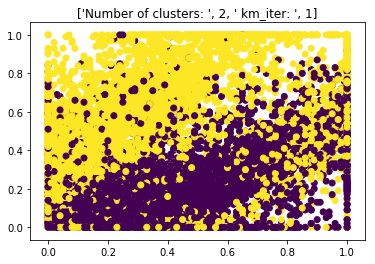

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2992.4081628



16
16


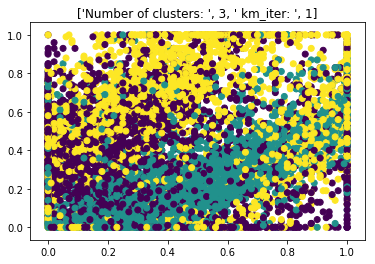

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3192.62210154



16
16
16


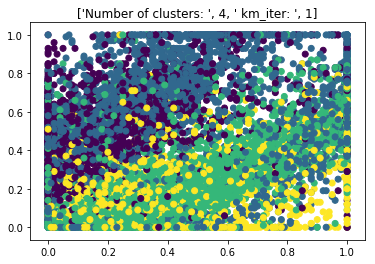

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3012.14776041



16
16
16
16


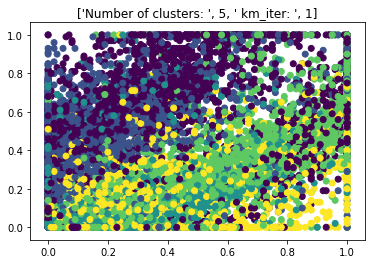

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3152.20592523



16
16
16
16
16


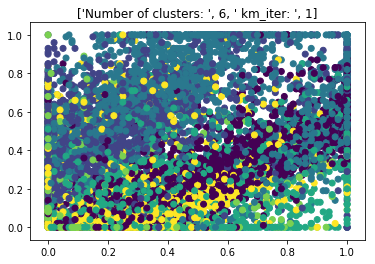

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2939.1815667



16
16
16
16
16
16


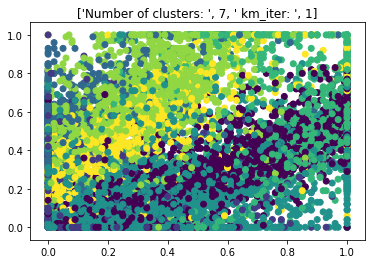

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2197.41986367



16
16
16
16
16
16
16


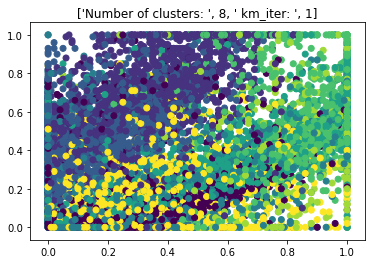

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2396.00521229



16
16
16
16
16
16
16
16


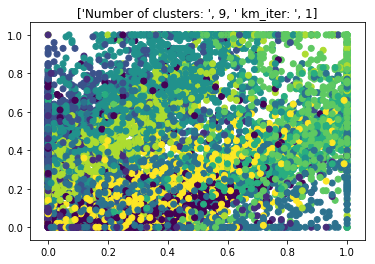

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2570.74238784



16
16
16
16
16
16
16
16
16


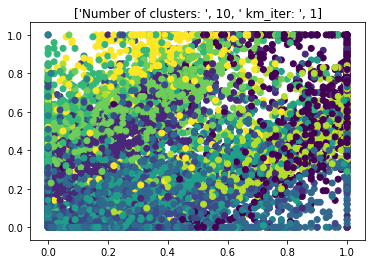

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2462.41040975



16
16
16
16
16
16
16
16
16
16


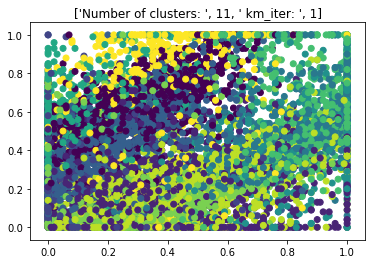

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2375.23047399



16
16
16
16
16
16
16
16
16
16
16


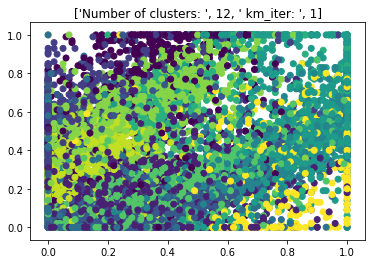

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2224.61962288



16
16
16
16
16
16
16
16
16
16
16
16


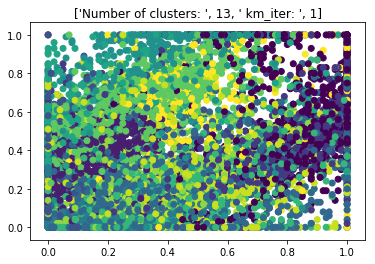

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2072.89620626



16
16
16
16
16
16
16
16
16
16
16
16
16


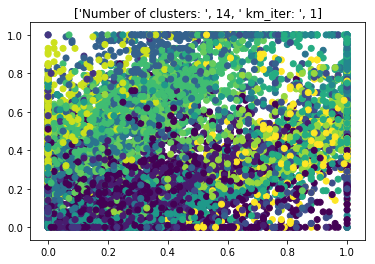

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2023.67698922



16
16
16
16
16
16
16
16
16
16
16
16
16
16


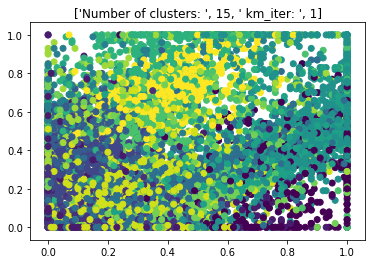

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2051.41781436



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


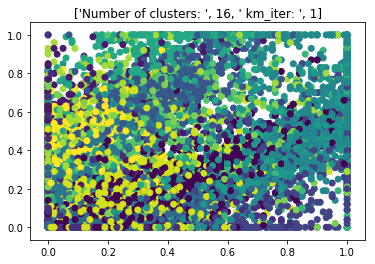

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1935.31604035



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


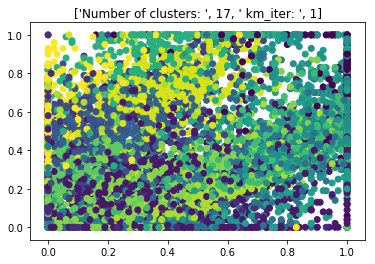

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1840.60125928



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


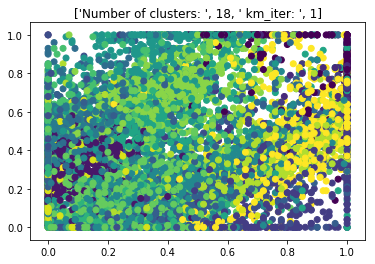

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1893.93769861



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


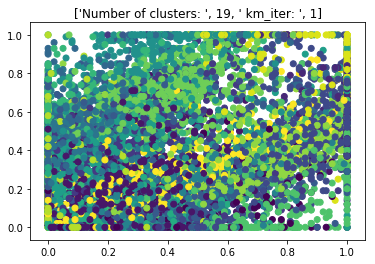

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1865.74365032





In [17]:
#check results

print "****** Performance evaluation with Pen BASED dataset *********\n\n\n" 

#load dataset PEN BASED
f="datasets/pen-based.arff"
data, meta = arff.loadarff(f)

#initialize data ndarrays data_num
#. data_num to cluster 
#. data_label: ground truth classification

data_num=np.zeros((len(data), len(data[0])-1))
data_label=np.zeros((len(data)))

i=0
for d in data:
    data_num[i,:]=[d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13],d[14],d[15]]
   
    data_label[i]=data[16][0]
    
                    
    i=i+1   


######### SET max_K and max_k_iter TO PLOT Bisecting K-means results for Iris

max_k_iter=2
plt.figure()
max_K=20
accuracies_ar=np.zeros([max_K-2,(max_k_iter-1)*2])


for wanted_K in range(2,max_K):
 
    
    r_array=np.zeros((max_k_iter-1)*2)
    
    for km_iter in range(1,max_k_iter):

        cluster_assingment=Bk_means(data_num,wanted_K,km_iter,0)
        #cluster_assingment=KMeans(wanted_K).fit_predict(data_num)
        plt.title(["Number of clusters: ",wanted_K," km_iter: " , km_iter] )
        #plt.subplot(2,2,wanted_K-1)
        plt.scatter(data_num[:, 0], data_num[:, 2], c=cluster_assingment)
        #plt.text(2, 0.65, ["Adjusted rand Index: " , adjusted_rand_score(data_label.flatten(), cluster_assingment.flatten())])
        #plt.xlabel(meta[0])
        #plt.ylabel(meta[1])
        plt.show()
        rand_score = sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        calinski = skmetrics.calinski_harabaz_score(data_num, cluster_assingment)
        r_array[2*(km_iter-1)]=rand_score
        r_array[2*km_iter-1]=calinski
        
        print "Adjusted rand Index: " , sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        #print "V measure score: " , sk_cluster_m.v_measure_score(data_label.flatten(), cluster_assingment)
        print "Calinski Harabaz Score: ", skmetrics.calinski_harabaz_score(data_num, cluster_assingment) 
        print "\n\n"
    
    accuracies_ar[wanted_K-2,:]=r_array[:]
    


#print accuracies_ar[:][0]
plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"Bisecting K-means accuracy")


****** Performance evaluation with Iris dataset *********



4


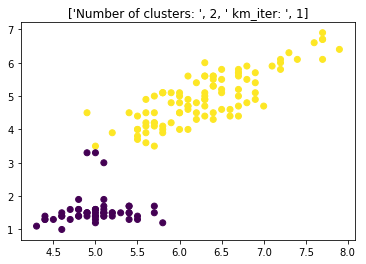

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4


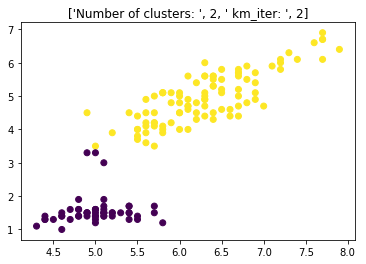

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4
4


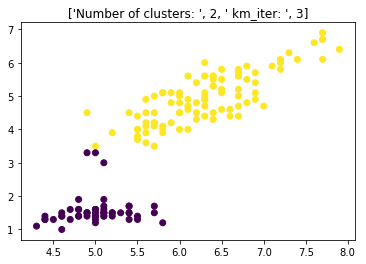

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4
4
4


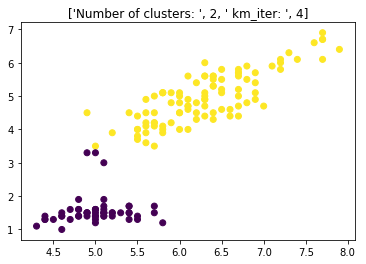

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4
4
4
4


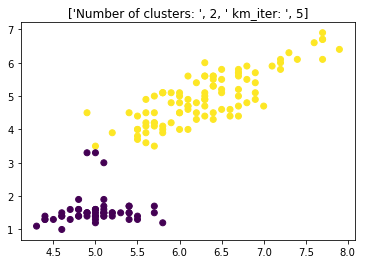

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4
4
4
4
4


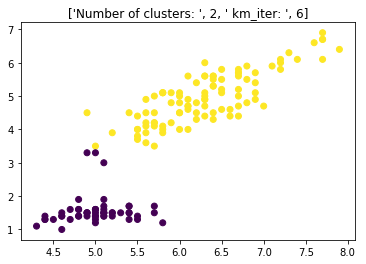

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4
4
4
4
4
4


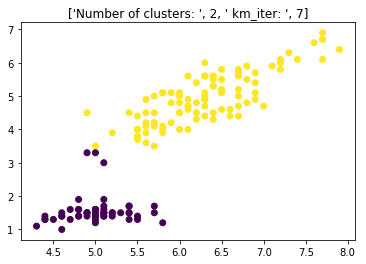

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4
4
4
4
4
4
4


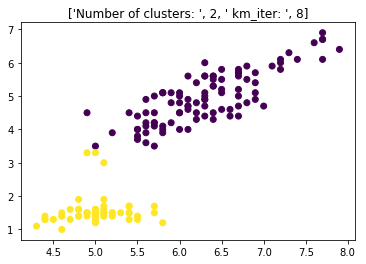

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4
4
4
4
4
4
4
4


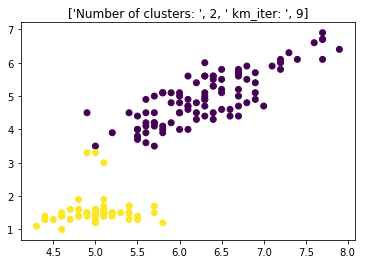

Adjusted rand Index:  0.920405050902
Calinski Harabaz Score:  513.303843352



4
4


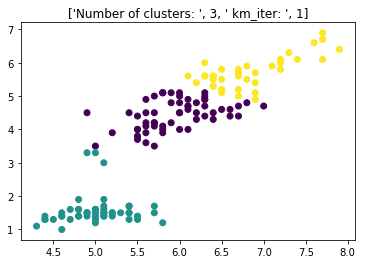

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4


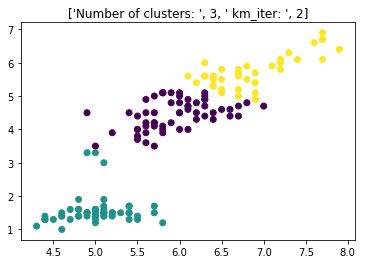

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4
4
4


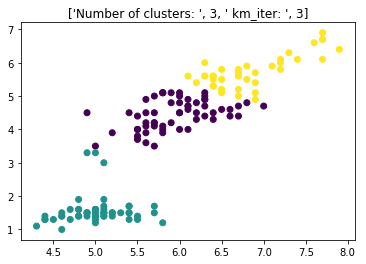

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4
4
4
4
4


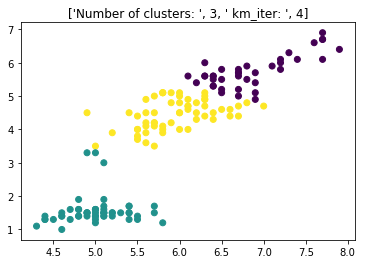

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4
4
4
4
4
4
4


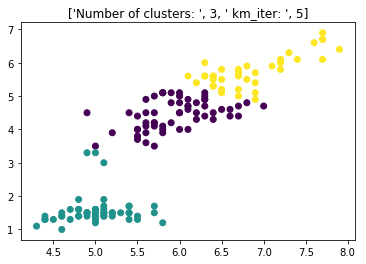

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4
4
4
4
4
4
4
4
4


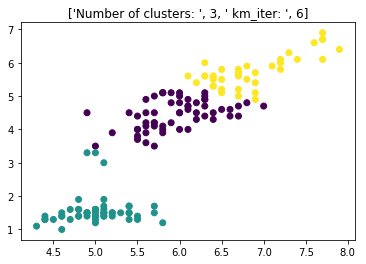

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4
4
4
4
4
4
4
4
4
4
4


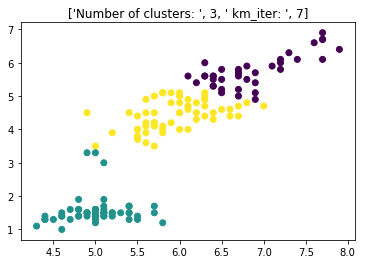

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


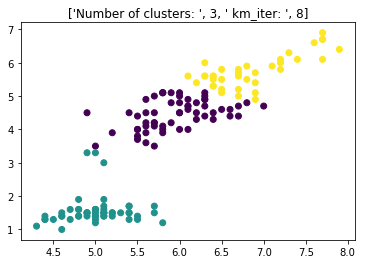

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


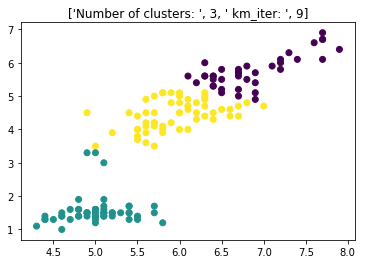

Adjusted rand Index:  0.535514897167
Calinski Harabaz Score:  520.633406372



4
4
4


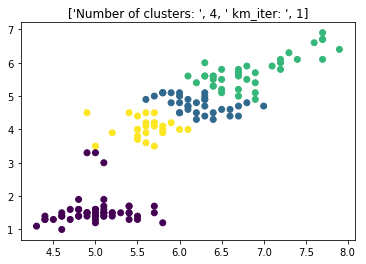

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4


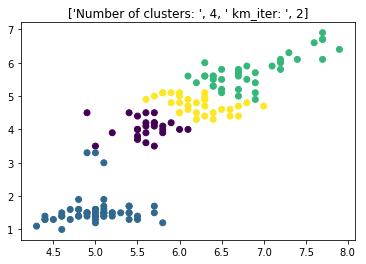

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4
4
4
4


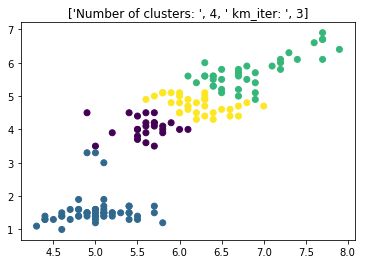

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4
4
4
4
4
4
4


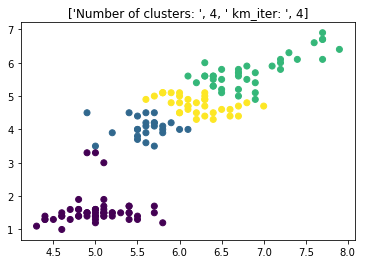

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


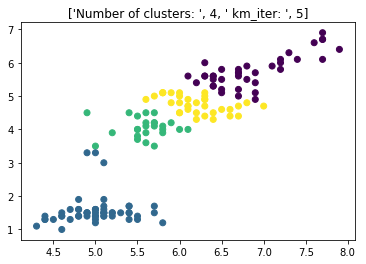

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


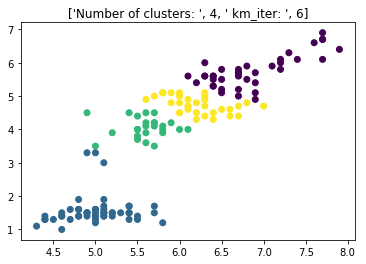

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


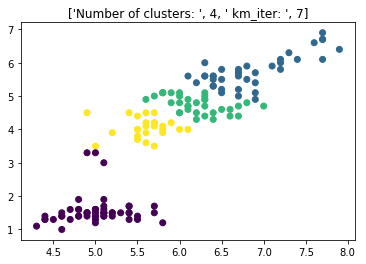

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


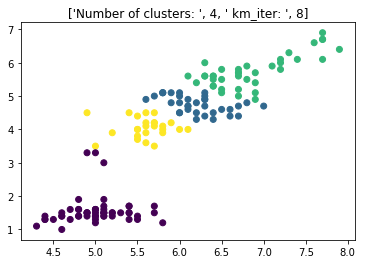

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


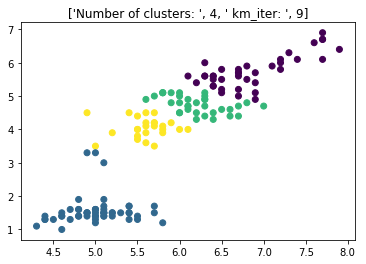

Adjusted rand Index:  0.397680963527
Calinski Harabaz Score:  427.250677562



4
4
4
4


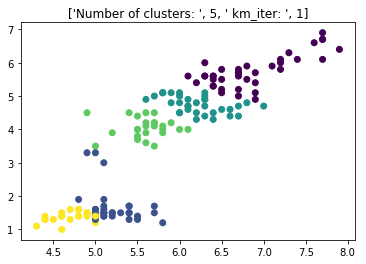

Adjusted rand Index:  0.312321943629
Calinski Harabaz Score:  358.43364063



4
4
4
4
4
4
4
4


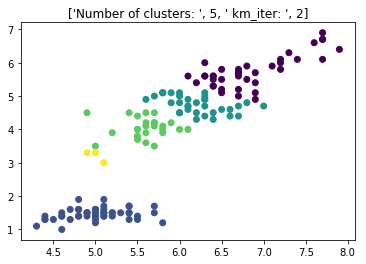

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4
4
4
4
4
4
4
4


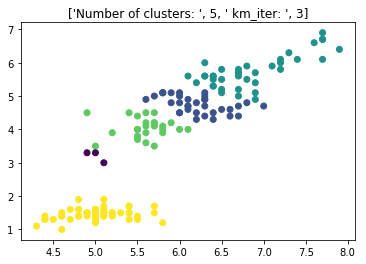

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


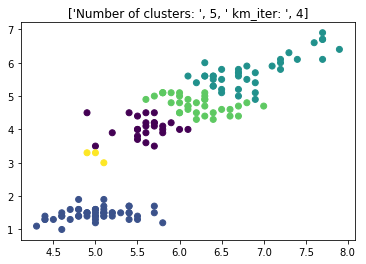

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


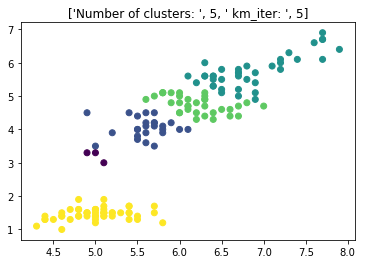

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


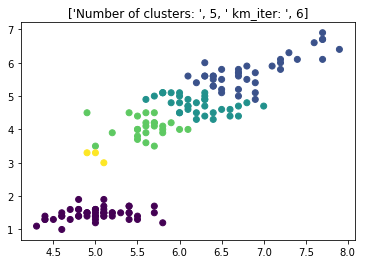

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


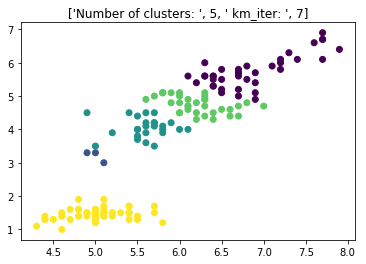

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


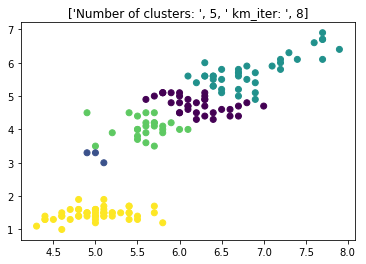

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


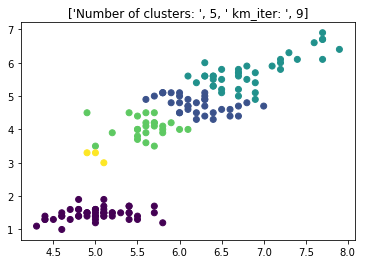

Adjusted rand Index:  0.424800142716
Calinski Harabaz Score:  401.379881054



4
4
4
4
4


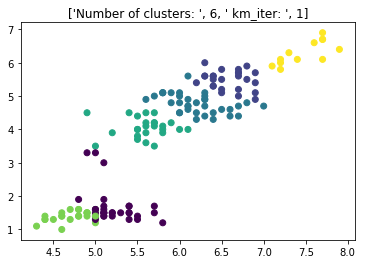

Adjusted rand Index:  0.265231916398
Calinski Harabaz Score:  362.975704804



4
4
4
4
4
4
4
4
4
4


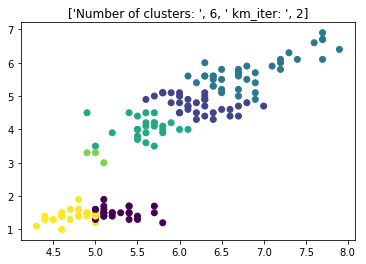

Adjusted rand Index:  0.326219967506
Calinski Harabaz Score:  373.017929513



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


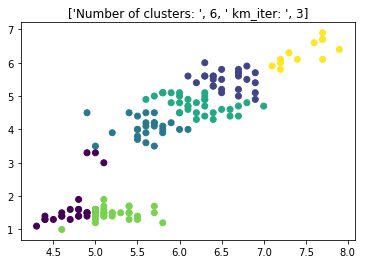

Adjusted rand Index:  0.270643619722
Calinski Harabaz Score:  377.819309867



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


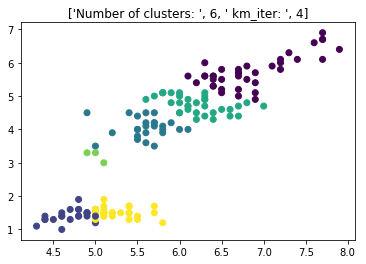

Adjusted rand Index:  0.326688706743
Calinski Harabaz Score:  373.08197599



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


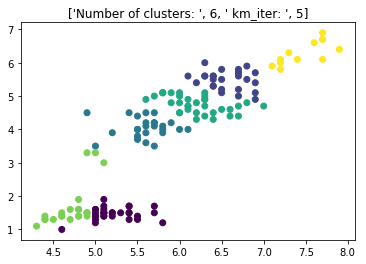

Adjusted rand Index:  0.270643619722
Calinski Harabaz Score:  377.819309867



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


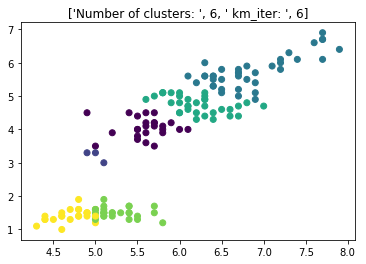

Adjusted rand Index:  0.326688706743
Calinski Harabaz Score:  373.08197599



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


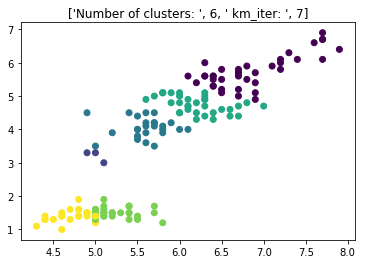

Adjusted rand Index:  0.326688706743
Calinski Harabaz Score:  373.08197599



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


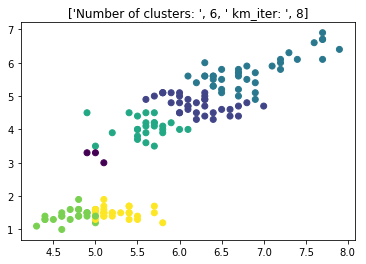

Adjusted rand Index:  0.326688706743
Calinski Harabaz Score:  373.08197599



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


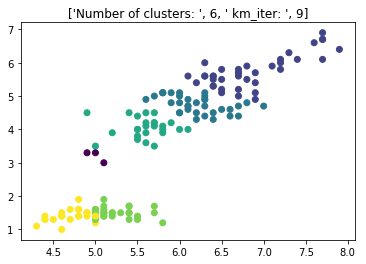

Adjusted rand Index:  0.326688706743
Calinski Harabaz Score:  373.08197599



4
4
4
4
4
4


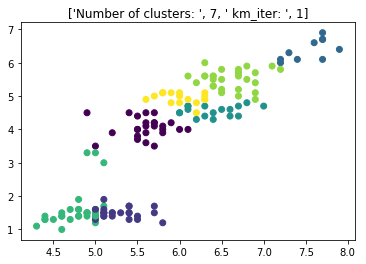

Adjusted rand Index:  0.224161503331
Calinski Harabaz Score:  344.531559493



4
4
4
4
4
4
4
4
4
4
4
4


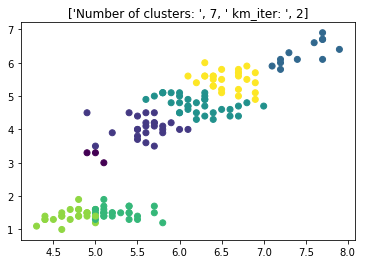

Adjusted rand Index:  0.278204704189
Calinski Harabaz Score:  421.625148396



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


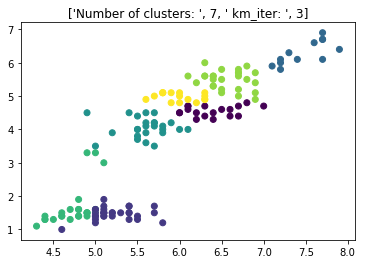

Adjusted rand Index:  0.226334265396
Calinski Harabaz Score:  346.662131292



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


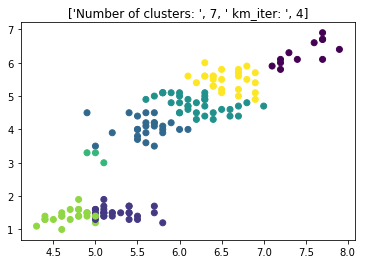

Adjusted rand Index:  0.278204704189
Calinski Harabaz Score:  421.625148396



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


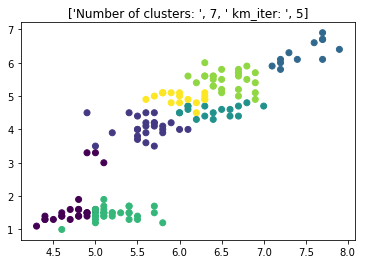

Adjusted rand Index:  0.226181192472
Calinski Harabaz Score:  346.564119369



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


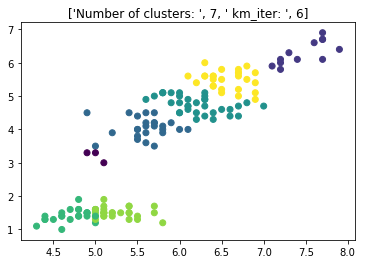

Adjusted rand Index:  0.278204704189
Calinski Harabaz Score:  421.625148396



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


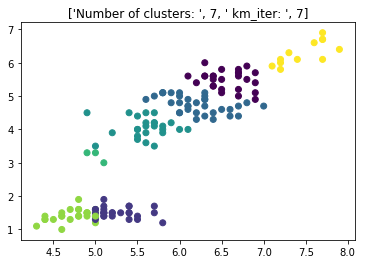

Adjusted rand Index:  0.278204704189
Calinski Harabaz Score:  421.625148396



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


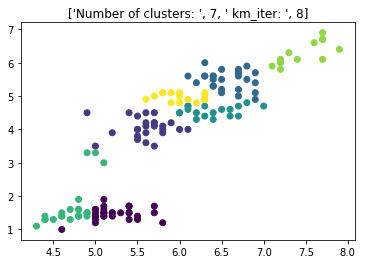

Adjusted rand Index:  0.226334265396
Calinski Harabaz Score:  346.662131292



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


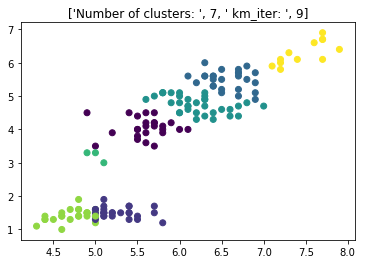

Adjusted rand Index:  0.278204704189
Calinski Harabaz Score:  421.625148396



4
4
4
4
4
4
4


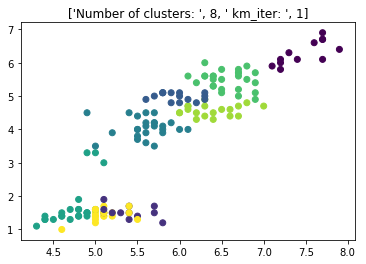

Adjusted rand Index:  0.193850386542
Calinski Harabaz Score:  312.194780529



4
4
4
4
4
4
4
4
4
4
4
4
4
4


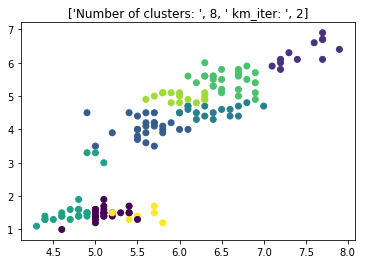

Adjusted rand Index:  0.201758416266
Calinski Harabaz Score:  313.105275938



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


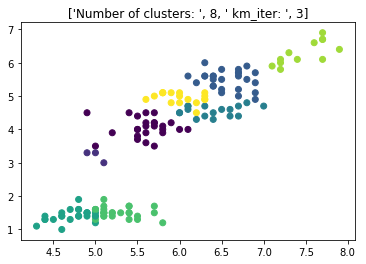

Adjusted rand Index:  0.233308121564
Calinski Harabaz Score:  411.034079328



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


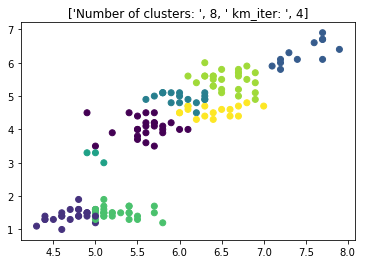

Adjusted rand Index:  0.233767055596
Calinski Harabaz Score:  411.138858233



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


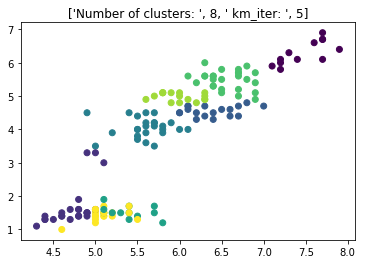

Adjusted rand Index:  0.193394592037
Calinski Harabaz Score:  312.466641221



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


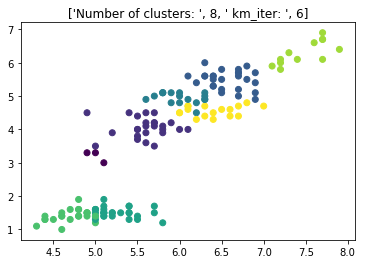

Adjusted rand Index:  0.233767055596
Calinski Harabaz Score:  411.138858233



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


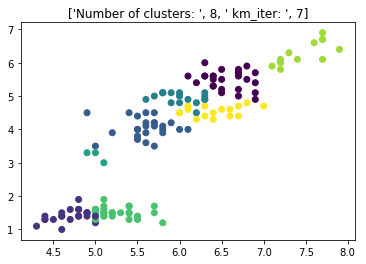

Adjusted rand Index:  0.233767055596
Calinski Harabaz Score:  411.138858233



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


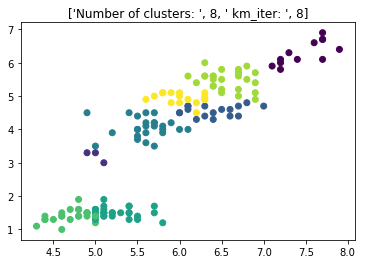

Adjusted rand Index:  0.233767055596
Calinski Harabaz Score:  411.138858233



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


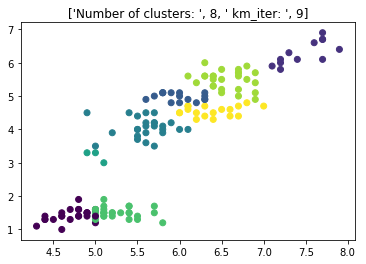

Adjusted rand Index:  0.233920044312
Calinski Harabaz Score:  411.295097254



4
4
4
4
4
4
4
4


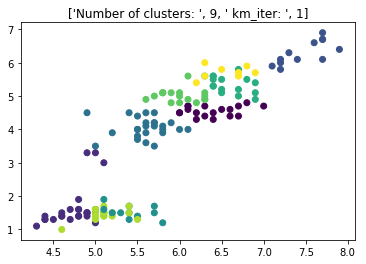

Adjusted rand Index:  0.170125520347
Calinski Harabaz Score:  286.757664057



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


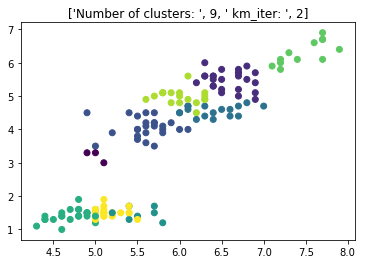

Adjusted rand Index:  0.211183597183
Calinski Harabaz Score:  387.386557245



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


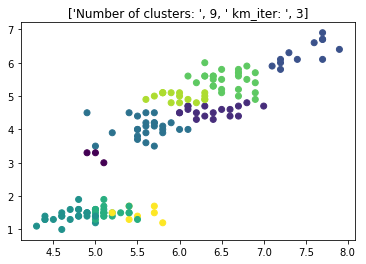

Adjusted rand Index:  0.212553584001
Calinski Harabaz Score:  382.686159175



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


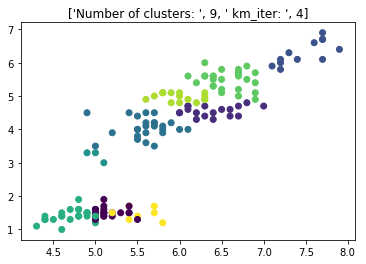

Adjusted rand Index:  0.212553584001
Calinski Harabaz Score:  382.686159175



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


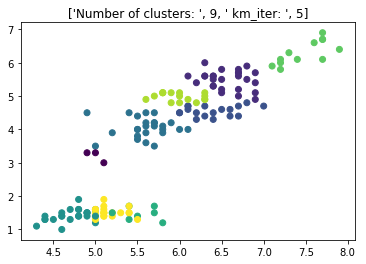

Adjusted rand Index:  0.212553584001
Calinski Harabaz Score:  382.686159175



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


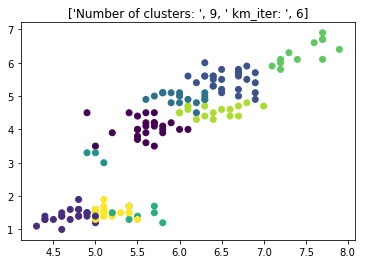

Adjusted rand Index:  0.21240134199
Calinski Harabaz Score:  382.531451733



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


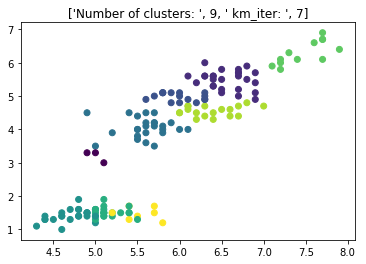

Adjusted rand Index:  0.212553584001
Calinski Harabaz Score:  382.686159175



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


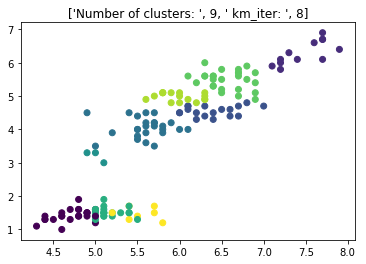

Adjusted rand Index:  0.212553584001
Calinski Harabaz Score:  382.686159175



4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


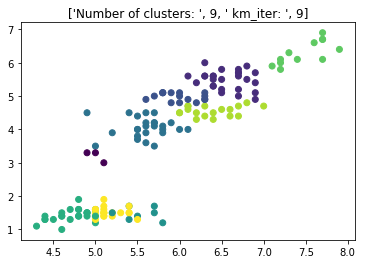

Adjusted rand Index:  0.212553584001
Calinski Harabaz Score:  382.686159175





In [12]:
#check results

print "****** Performance evaluation with Iris dataset *********\n\n\n" 

#load dataset IRIS
f="datasets/iris.arff"
data, meta = arff.loadarff(f)

#initialize data ndarrays data_num
#. data_num to cluster 
#. data_label: ground truth classification

data_num=np.zeros((len(data), len(data[0])-1))
data_label=np.zeros((len(data)))

i=0
for d in data:
    data_num[i,:]=[d[0],d[1],d[2],d[3]]
    if d[4]=="Iris-setosa":
        data_label[i]=0
    if d[4]=="Iris-versicolor":
        data_label[i]=1
    if d[4]=="Iris-virginica":
        data_label[i]=1
                    
    i=i+1   


######### SET max_K and max_k_iter TO PLOT Bisecting K-means results for Iris

max_k_iter=10
plt.figure()
max_K=10
accuracies_ar=np.zeros([max_K-2,(max_k_iter-1)*2])


for wanted_K in range(2,max_K):
 
    
    r_array=np.zeros((max_k_iter-1)*2)
    
    for km_iter in range(1,max_k_iter):

        cluster_assingment=Bk_means(data_num,wanted_K,km_iter,0)
        #cluster_assingment=KMeans(wanted_K).fit_predict(data_num)
        plt.title(["Number of clusters: ",wanted_K," km_iter: " , km_iter] )
        #plt.subplot(2,2,wanted_K-1)
        plt.scatter(data_num[:, 0], data_num[:, 2], c=cluster_assingment)
        #plt.text(2, 0.65, ["Adjusted rand Index: " , adjusted_rand_score(data_label.flatten(), cluster_assingment.flatten())])
        #plt.xlabel(meta[0])
        #plt.ylabel(meta[1])
        plt.show()
        rand_score = sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        calinski = skmetrics.calinski_harabaz_score(data_num, cluster_assingment)
        r_array[2*(km_iter-1)]=rand_score
        r_array[2*km_iter-1]=calinski
        
        print "Adjusted rand Index: " , sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        #print "V measure score: " , sk_cluster_m.v_measure_score(data_label.flatten(), cluster_assingment)
        print "Calinski Harabaz Score: ", skmetrics.calinski_harabaz_score(data_num, cluster_assingment) 
        print "\n\n"
    
    accuracies_ar[wanted_K-2,:]=r_array[:]
    


#print accuracies_ar[:][0]
plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"Bisecting K-means accuracy")




#### Bisecting Kmeans: Compare algorithm performance to ground truth K=3 (IRIS)


In [9]:

d_Iris_setosa=data_num[np.where(data["class"]=="Iris-setosa")]
d_Iris_versicolor=data_num[np.where(data["class"]=="Iris-versicolor")]
d_Iris_virginica=data_num[np.where(data["class"]=="Iris-virginica")]

cluster_assingment=Bk_means(data_num,3,2,0)

results_c1=data_num[np.where(cluster_assingment[:]==0),:][0]
results_c2=data_num[np.where(cluster_assingment[:]==1),:][0]
results_c3=data_num[np.where(cluster_assingment[:]==2),:][0]


print len(results_c1), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, list(results_c1)))
d=len(sett)
print"Intersection of C1 with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1 with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1  with Iris virgini ",d

print "************************************* \n"

print len(results_c2), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Iris virgini ",d

print "************************************* "

print len(results_c3), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Iris virgini\n ",d



53 entries were classified in one cluster of which:

Intersection of C1 with Iris setosa  48
Intersection of C1 with Iris versicolor  3
Intersection of C1  with Iris virgini  0
************************************* 

59 entries were classified in one cluster of which:

intersection with Iris setosa  0
intersection with Iris versicolor  45
intersection with Iris virgini  13
************************************* 
38 entries were classified in one cluster of which:

intersection with Iris setosa  0
intersection with Iris versicolor  2
intersection with Iris virgini
  36


In [64]:
print accuracies_ar

[[  9.20405051e-01   5.13303843e+02   9.20405051e-01   5.13303843e+02
    9.20405051e-01   5.13303843e+02   9.20405051e-01   5.13303843e+02]
 [  5.39139013e-01   5.20263779e+02   5.35514897e-01   5.20633406e+02
    5.35514897e-01   5.20633406e+02   5.35514897e-01   5.20633406e+02]
 [  3.97201929e-01   4.30569285e+02   3.97680964e-01   4.27250678e+02
    3.97680964e-01   4.27250678e+02   3.97680964e-01   4.27250678e+02]
 [  4.24800143e-01   4.01379881e+02   3.13780420e-01   3.74278906e+02
    3.14249071e-01   3.71012899e+02   3.19155389e-01   3.71109109e+02]
 [  2.63840888e-01   3.62048659e+02   3.36073945e-01   3.70456253e+02
    3.26688707e-01   3.73081976e+02   2.70643620e-01   3.77819310e+02]
 [  2.79595828e-01   4.23081596e+02   2.19264903e-01   3.45551154e+02
    2.77741094e-01   4.21530067e+02   2.78204704e-01   4.21625148e+02]
 [  1.99323646e-01   3.12999653e+02   2.33767056e-01   4.11138858e+02
    2.33308122e-01   4.10172331e+02   2.33767056e-01   4.11138858e+02]
 [  2.0509997